In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
import numpy as np
import copy
from autograd_lib import autograd_lib
from collections import defaultdict
import math

# define preferred pytorch device (gpu, if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using " + device + " device")

C:\Users\FJ\.conda\envs\ML_py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


# HW1-1: Deep VS Shallow #

## 1.1 Simulate a function ##

In [2]:
"""
Define 3 DNN models, with the same amount of parameters but varying depths

"""

# total parameters: 571
class DNNModelA(nn.Module):
    def __init__(self):
        super(DNNModelA, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 190),
            nn.LeakyReLU(),
            nn.Linear(190, 1))

    def forward(self, x):
        return self.net(x)

# total parameters: 572
class DNNModelB(nn.Module):
    def __init__(self):
        super(DNNModelB, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 18),
            nn.LeakyReLU(),
            nn.Linear(18, 15),
            nn.LeakyReLU(),
            nn.Linear(15, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 1))

    def forward(self, x):
        return self.net(x)

# total parameters: 571
class DNNModelC(nn.Module):
    def __init__(self):
        super(DNNModelC, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 1))
    def forward(self, x):
        return self.net(x)


# instantiate DNN models, move them to main computing device
model_A_f1 = DNNModelA().to(device)
model_B_f1 = DNNModelB().to(device)
model_C_f1 = DNNModelC().to(device)
model_A_f2 = DNNModelA().to(device)
model_B_f2 = DNNModelB().to(device)
model_C_f2 = DNNModelC().to(device)

# print model summaries
print(summary(model_A_f1))
print()
print(summary(model_B_f1))
print()
print(summary(model_C_f1))

Layer (type:depth-idx)                   Param #
DNNModelA                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       380
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       191
Total params: 571
Trainable params: 571
Non-trainable params: 0

Layer (type:depth-idx)                   Param #
DNNModelB                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       20
│    └─LeakyReLU: 2-2                    --
│    └─Linear: 2-3                       198
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       285
│    └─LeakyReLU: 2-6                    --
│    └─Linear: 2-7                       64
│    └─LeakyReLU: 2-8                    --
│    └─Linear: 2-9                       5
Total params: 572
Trainable params: 572
Non-trainable params: 0

Layer (type:depth-idx)                   Param #
DNNModelC       

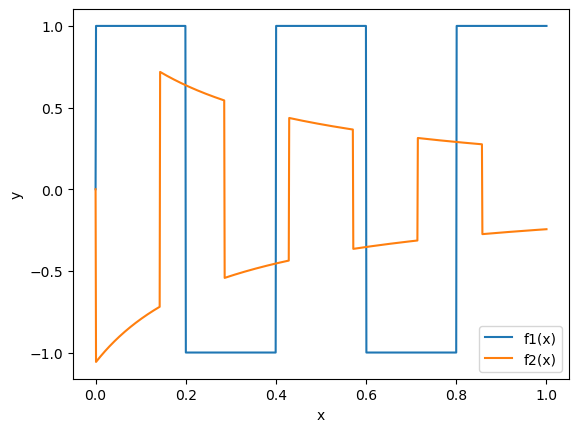

In [3]:
"""
Define functions to emulate and sample datasets from them (within the [0, 1] domain)

"""

# f1(x) = sgn(sin(5πx))
def wave_1(x):
    return np.sign(np.sin(5 * np.pi * x))

# f2(x) = sgn(sin(5πx))
def wave_2(x):
    return -np.sign(np.sin(7 * np.pi * x))/(np.pi * (x + 0.3))

# generate training data
X_f = np.linspace(0, 1, 1000)
y_f1 = wave_1(X_f)
y_f2 = wave_2(X_f)

# convert numpy arrays to Tensors
tensor_x_f = torch.Tensor(X_f)
tensor_y_f1 = torch.Tensor(y_f1)
tensor_y_f2 = torch.Tensor(y_f2)
tensor_x_f = tensor_x_f.view(tensor_x_f.shape[0], 1)
tensor_y_f1 = tensor_y_f1.view(tensor_y_f1.shape[0], 1)
tensor_y_f2 = tensor_y_f2.view(tensor_y_f2.shape[0], 1)

# create datasets and dataloaders
dataset_f1 = TensorDataset(tensor_x_f, tensor_y_f1)
dataset_f2 = TensorDataset(tensor_x_f, tensor_y_f2)
dataloader_f1 = DataLoader(dataset_f1, batch_size = 256, shuffle = True)
dataloader_f2 = DataLoader(dataset_f2, batch_size = 256, shuffle = True)

# plot functions for convenience
plt.plot(X_f, y_f1)
plt.plot(X_f, y_f2)
plt.legend(["f1(x)", "f2(x)"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [4]:
"""
Train all DNN models 

"""

# function to train a DNN model
def train(dataloader, model, epochs = 20000, lr=1e-3):
    # define cost function (mean squared error for regression) and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) # change this to SGD with 1e-2 learning rate

    # set model to train mode
    model.train()
    
    # train and store the training loss for all epochs
    training_loss = []
    for epoch in range(epochs):
        epoch_loss = 0.0

        # iterate over batches
        for batch, (X_train, y_train) in enumerate(dataloader): 
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            # reset gradients to zero 
            optimizer.zero_grad()

            # compute predictions, loss, and take optimizer step
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optimizer.step()
            
            # update epoch loss
            epoch_loss += loss.item() / len(dataloader)
        
        # append loss for current epoch
        training_loss.append(epoch_loss)
        
        # print training info
        if (epoch % 5000 == 0) or (epoch == (epochs-1)):
            print("Epoch " + str(epoch) + ", loss: " + str(epoch_loss))
    
    # return list of epoch training losses
    return training_loss


# train models on f1(x)
print("Training model A on f1(x)...")
training_loss_model_A_f1 = train(dataloader_f1, model_A_f1)
print("\nTraining model B on f1(x)...")
training_loss_model_B_f1 = train(dataloader_f1, model_B_f1)
print("\nTraining model C on f1(x)...")
training_loss_model_C_f1 = train(dataloader_f1, model_C_f1)

# train models on f2(x)
print("\nTraining model A on f2(x)...")
training_loss_model_A_f2 = train(dataloader_f2, model_A_f2)
print("\nTraining model B on f2(x)...")
training_loss_model_B_f2 = train(dataloader_f2, model_B_f2)
print("\nTraining model C on f2(x)...")
training_loss_model_C_f2 = train(dataloader_f2, model_C_f2)

Training model A on f1(x)...
Epoch 0, loss: 1.0043365806341171
Epoch 5000, loss: 0.11586329154670238
Epoch 10000, loss: 0.10741095617413521
Epoch 15000, loss: 0.10348337888717651
Epoch 19999, loss: 0.07359877321869135

Training model B on f1(x)...
Epoch 0, loss: 1.002301663160324
Epoch 5000, loss: 0.009375020395964384
Epoch 10000, loss: 0.007665316668862943
Epoch 15000, loss: 0.008294179453514516
Epoch 19999, loss: 0.011186702526174486

Training model C on f1(x)...
Epoch 0, loss: 1.0339878797531128
Epoch 5000, loss: 0.018945507472380996
Epoch 10000, loss: 0.008184535428881645
Epoch 15000, loss: 0.00844213814707473
Epoch 19999, loss: 0.02930898079648614

Training model A on f2(x)...
Epoch 0, loss: 0.24510136991739273
Epoch 5000, loss: 0.040580328553915024
Epoch 10000, loss: 0.018515657633543015
Epoch 15000, loss: 0.014724402455613017
Epoch 19999, loss: 0.01285317586734891

Training model B on f2(x)...
Epoch 0, loss: 0.4432820528745651
Epoch 5000, loss: 0.0073848539614118636
Epoch 10000,

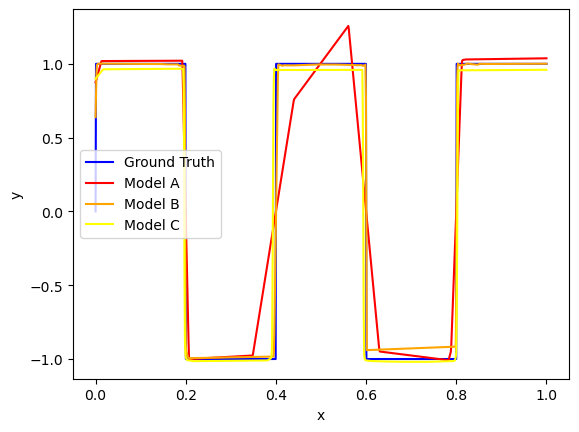

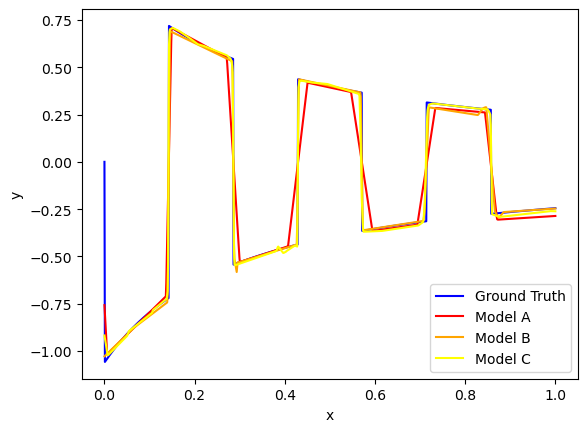

In [5]:
""" 
Plot model outputs VS ground truth functions 

"""

# compute model outputs and convert to numpy
tensor_x_f = tensor_x_f.to(device)
y_model_A_f1 = model_A_f1(tensor_x_f).cpu().detach().numpy().squeeze()
y_model_B_f1 = model_B_f1(tensor_x_f).cpu().detach().numpy().squeeze()
y_model_C_f1 = model_C_f1(tensor_x_f).cpu().detach().numpy().squeeze()
y_model_A_f2 = model_A_f2(tensor_x_f).cpu().detach().numpy().squeeze()
y_model_B_f2 = model_B_f2(tensor_x_f).cpu().detach().numpy().squeeze()
y_model_C_f2 = model_C_f2(tensor_x_f).cpu().detach().numpy().squeeze()


# plot f1(x) predictions
plt.plot(X_f, y_f1, color = 'blue')
plt.plot(X_f, y_model_A_f1, color = 'red')
plt.plot(X_f, y_model_B_f1, color = 'orange')
plt.plot(X_f, y_model_C_f1, color = 'yellow')
plt.legend(["Ground Truth", "Model A", "Model B", "Model C"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# plot f2(x) predictions
plt.plot(X_f, y_f2, color = 'blue')
plt.plot(X_f, y_model_A_f2, color = 'red')
plt.plot(X_f, y_model_B_f2, color = 'orange')
plt.plot(X_f, y_model_C_f2, color = 'yellow')
plt.legend(["Ground Truth", "Model A", "Model B", "Model C"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

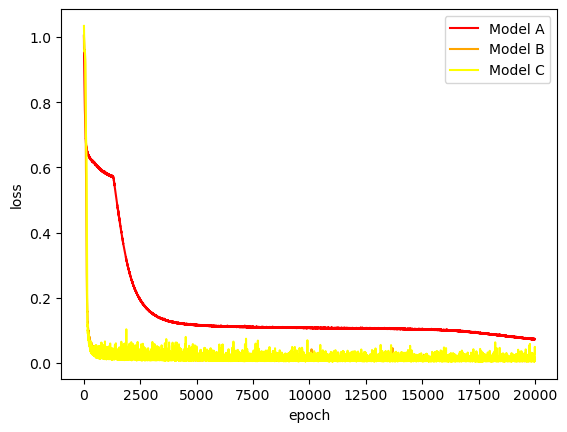

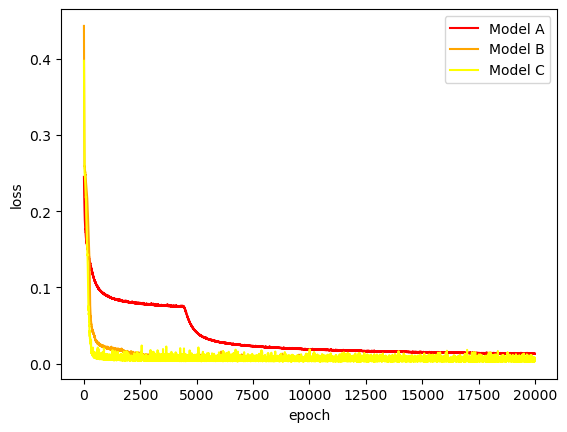

In [6]:
# plot training losses of f1 training
plt.plot(training_loss_model_A_f1, color='red')
plt.plot(training_loss_model_B_f1, color='orange')
plt.plot(training_loss_model_C_f1, color='yellow')
plt.legend(["Model A", "Model B", "Model C"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# plot training losses of f2 training
plt.plot(training_loss_model_A_f2, color='red')
plt.plot(training_loss_model_B_f2, color='orange')
plt.plot(training_loss_model_C_f2, color='yellow')
plt.legend(["Model A", "Model B", "Model C"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## 1.2 Train on actual task (CIFAR-10 classification) ## 

In [7]:
"""
CIFAR-10 dataset

"""
# get CIFAR10 training and test sets
data_transforms = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
CIFAR10_trainset = datasets.CIFAR10(root='./CIFAR10_data/', train = True, download=True, transform=data_transforms)
CIFAR10_testset = datasets.CIFAR10(root='./CIFAR10_data/', train = False, download=True, transform=data_transforms)

# define train and test data loaders
trainset_loader = DataLoader(CIFAR10_trainset, batch_size=64, shuffle=True, num_workers=2)
testset_loader = DataLoader(CIFAR10_testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
"""
Define 3 CNN models to train on CIFAR-10. 

"""

class CNNModelA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(6*14*14, 10)
    
    def forward(self, x):        # input size:  [m, 3, 32, 32]
        x = F.relu(self.conv(x)) # output size: [m, 6, 28, 28]
        x = self.pool(x)         # output size: [m, 6, 14, 14]
        x = torch.flatten(x, 1)  # output size: [m, 1176]
        x = self.fc(x)           # output size: [m, 10]
        return x

class CNNModelB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 15, 5)
        self.fc = nn.Linear(15*5*5, 10)
    
    def forward(self, x):         # input size:  [m, 3, 32, 32]
        x = F.relu(self.conv1(x)) # output size: [m, 9, 28, 28]
        x = self.pool(x)          # output size: [m, 9, 14, 14]
        x = F.relu(self.conv2(x)) # output size: [m, 15, 10, 10]
        x = self.pool(x)          # output size: [m, 15, 5, 5]
        x = torch.flatten(x, 1)   # output size: [m, 375]
        x = self.fc(x)            # output size: [m, 10]
        return x


class CNNModelC(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.conv3 = nn.Conv2d(12, 15, 5)
        self.conv4 = nn.Conv2d(15, 18, 5)
        self.fc = nn.Linear(18*2*2, 10)
    
    def forward(self, x):         # input size:  [m, 3, 32, 32]
        x = F.relu(self.conv1(x)) # output size: [m, 6, 28, 28]
        x = self.pool(x)          # output size: [m, 6, 14, 14]
        x = F.relu(self.conv2(x)) # output size: [m, 12, 10, 10]
        x = F.relu(self.conv3(x)) # output size: [m, 15, 6, 6]
        x = F.relu(self.conv4(x)) # output size: [m, 18, 2, 2]
        x = torch.flatten(x, 1)   # output size: [m, 72]
        x = self.fc(x)            # output size: [m, 10]
        return x

# instantiate models and move them to preferred computing device
cnn_model_A = CNNModelA().to(device)
cnn_model_B = CNNModelB().to(device)
cnn_model_C = CNNModelC().to(device)

# print model summaries
print(summary(cnn_model_A))
print()
print(summary(cnn_model_B))
print()
print(summary(cnn_model_C))

Layer (type:depth-idx)                   Param #
CNNModelA                                --
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Linear: 1-3                            11,770
Total params: 12,226
Trainable params: 12,226
Non-trainable params: 0

Layer (type:depth-idx)                   Param #
CNNModelB                                --
├─Conv2d: 1-1                            684
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            3,390
├─Linear: 1-4                            3,760
Total params: 7,834
Trainable params: 7,834
Non-trainable params: 0

Layer (type:depth-idx)                   Param #
CNNModelC                                --
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            1,812
├─Conv2d: 1-4                            4,515
├─Conv2d: 1-5                            6,768
├─Linear: 1-6                  

In [9]:
"""
Train and evaluate all CNN models

"""

# function to evaluate model accuracy against the provided dataset
def evaluate(dataloader, model): 
    model.eval()
    correct = 0
    
    # compute amount of correct predictions (class with max predicted probability == ground-truth label)
    for input_data, labels in dataloader: 
        input_data = input_data.to(device)
        labels = labels.to(device)
        y_pred = model(input_data)
        y_pred_one_hot = y_pred.data.max(1, keepdim=True)[1]
        correct += y_pred_one_hot.eq(labels.data.view_as(y_pred_one_hot)).cpu().sum()

    # return % accuracy 
    return 100 * correct.item() / len(dataloader.dataset)
    
    
# function to train a CNN model on the provided dataset for 1 epoch
def train_cnn(dataloader, model):
    # define cost function (cross entropy loss for classification) and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # set model to train mode
    model.train()

    # train and store epoch training loss
    epoch_training_loss = 0.0
    for batch, (X_train, y_train) in enumerate(dataloader): 
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # reset gradients to zero
        optimizer.zero_grad()

        # compute model predictions and loss
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        
        # perform optimization step
        loss.backward()
        optimizer.step()

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_training_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_training_loss

# function to perform the main train-evaluate cycle
def train_and_evaluate(trainset_loader, testset_loader, model, epochs=50):
    
    # keep track of training loss, train accuracy and test accuracy for all epochs
    training_loss = []
    train_accuracy = []
    test_accuracy = []
    
    for epoch in range(epochs):
        # train for one epoch
        epoch_training_loss = train_cnn(trainset_loader, model)
        training_loss.append(epoch_training_loss)
        
        # evaluate accuracy on train set 
        epoch_train_accuracy = evaluate(trainset_loader, model)
        train_accuracy.append(epoch_train_accuracy)
        
        # evaluate accuracy on test set 
        epoch_test_accuracy = evaluate(testset_loader, model)
        test_accuracy.append(epoch_test_accuracy)

        # print info
        if (epoch % 10 == 0) or (epoch == (epochs-1)):
            print("Epoch " + str(epoch) + ", training loss: " + str(epoch_training_loss) 
                + ", train accuracy: " + str(epoch_train_accuracy) + "%"
                + ", test accuracy: " + str(epoch_test_accuracy) + "%")
            
    # return training loss, train accuracy and test accuracy for all epochs
    return training_loss, train_accuracy, test_accuracy


# train all models on CIFAR-10 dataset
print("Training model A on CIFAR-10...")
training_loss_A, train_accuracy_A, test_accuracy_A = train_and_evaluate(trainset_loader, testset_loader, cnn_model_A)
print("\nTraining model B on CIFAR-10...")
training_loss_B, train_accuracy_B, test_accuracy_B = train_and_evaluate(trainset_loader, testset_loader, cnn_model_B)
print("\nTraining model C on CIFAR-10...")
training_loss_C, train_accuracy_C, test_accuracy_C = train_and_evaluate(trainset_loader, testset_loader, cnn_model_C)

Training model A on CIFAR-10...
Epoch 0, training loss: 1.6482669029699273, train accuracy: 48.13%, test accuracy: 46.83%
Epoch 10, training loss: 1.1543530629723877, train accuracy: 61.104%, test accuracy: 57.21%
Epoch 20, training loss: 1.1128592097850707, train accuracy: 62.384%, test accuracy: 57.53%
Epoch 30, training loss: 1.0921263626164481, train accuracy: 63.13%, test accuracy: 57.49%
Epoch 40, training loss: 1.0753072659530292, train accuracy: 63.066%, test accuracy: 57.53%
Epoch 49, training loss: 1.0667075815103242, train accuracy: 64.014%, test accuracy: 57.62%

Training model B on CIFAR-10...
Epoch 0, training loss: 1.609584072819145, train accuracy: 49.614%, test accuracy: 49.15%
Epoch 10, training loss: 1.0127452554757639, train accuracy: 65.052%, test accuracy: 63.26%
Epoch 20, training loss: 0.9338431758496468, train accuracy: 68.512%, test accuracy: 65.12%
Epoch 30, training loss: 0.8898353626965877, train accuracy: 69.532%, test accuracy: 65.67%
Epoch 40, training l

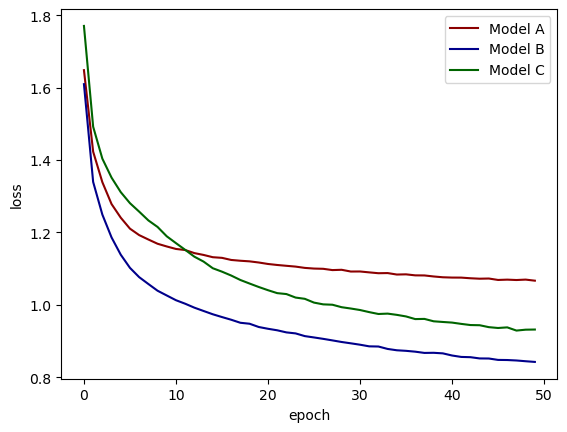

In [10]:
""" 
Plot training loss 

"""
plt.plot(training_loss_A, color='darkred')
plt.plot(training_loss_B, color='darkblue')
plt.plot(training_loss_C, color='darkgreen')
plt.legend(["Model A", "Model B", "Model C"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

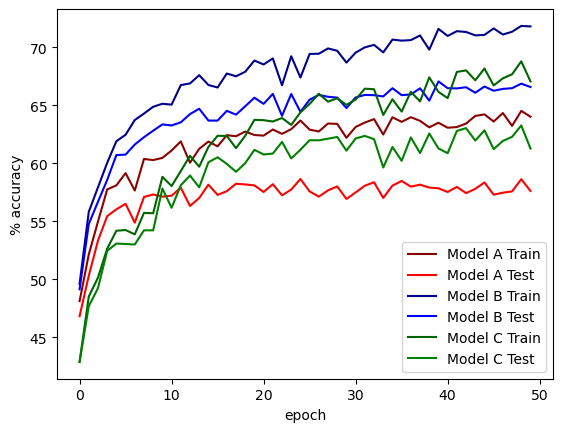

In [11]:
""" 
Plot accuracy 

"""
plt.plot(train_accuracy_A, color='darkred')
plt.plot(test_accuracy_A, color='red')
plt.plot(train_accuracy_B, color='darkblue')
plt.plot(test_accuracy_B, color='blue')
plt.plot(train_accuracy_C, color='darkgreen')
plt.plot(test_accuracy_C, color='green')
plt.legend(["Model A Train","Model A Test","Model B Train","Model B Test","Model C Train","Model C Test"])
plt.xlabel("epoch")
plt.ylabel("% accuracy")
plt.show()

# HW1-2: Optimization #

## 2.1 Visualize the optimization process ##

In [12]:
def shifted_sync(x):
    return np.sin(5 * np.pi * (x + 0.0001))/(5 * np.pi * (x + 0.0001))

# generate training data
X_f = np.linspace(0, 1, 1000)
y_f1 = shifted_sync(X_f)

# convert numpy arrays to Tensors
tensor_x_f = torch.Tensor(X_f)
tensor_y_f1 = torch.Tensor(y_f1)
tensor_x_f = tensor_x_f.view(tensor_x_f.shape[0], 1)
tensor_y_f1 = tensor_y_f1.view(tensor_y_f1.shape[0], 1)

# create datasets and dataloaders
dataset_f1 = TensorDataset(tensor_x_f, tensor_y_f1)
dataloader_f1 = DataLoader(dataset_f1, batch_size = 256, shuffle = True)

In [13]:
# Using a simple DNN model
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100), 
            nn.LeakyReLU(),
            nn.Linear(100, 1))

    def forward(self, x):
        return self.net(x)

In [14]:
# function to train a DNN model
def train(dataloader, model, epochs = 1500, lr=4e-3):
    # define cost function (mean squared error for regression) and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)  # was Adam with lr=1e-3

    # set model to train mode
    model.train()
    
    # every 3 epochs store: parameters, loss, gradient norm
    parameter_backup_i = []
    training_loss_i = []
    gradient_norm_i = []
    
    # train model for given epochs
    for epoch in range(epochs):
        epoch_loss = 0.0

        # iterate over batches
        for batch, (X_train, y_train) in enumerate(dataloader): 
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            # reset gradients to zero 
            optimizer.zero_grad()

            # compute predictions, loss, and take optimizer step
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optimizer.step()
            
            # update epoch loss
            epoch_loss += loss.item() / len(dataloader)
        
        # collect parameters, loss and grad norm every 3 epochs
        if epoch % 3 == 0: 
            # store params and loss
            parameter_backup_i.append(copy.deepcopy(model.state_dict()))
            training_loss_i.append(epoch_loss)
            
            # compute grad L2 norm
            grad_all = 0.0
            for p in model.parameters(): 
                grad = 0.0
                if p.grad is not None:
                    grad = (p.grad.cpu().data.numpy() ** 2).sum()
                grad_all += grad
            grad_norm = grad_all ** 0.5
            
            # store grad norm
            gradient_norm_i.append(grad_norm)
    
    # return list of epoch training losses
    return parameter_backup_i, training_loss_i, gradient_norm_i



# dictionary mapping from training session number to the corresponding list of parameters (one set of params every 3 epochs)
parameter_backups = {}

# dictionary mapping from training session number to the corresponding list of training loss values (associated to above params)
training_loss = {}

# dictionary mapping from training session number to the corresponding list of grad norm values (associated to above params)
gradient_norm = {}


# train 8 times
training_sessions = 8
for i in range(training_sessions): 
    
    # reset model before new training session
    dnn_model = DNNModel().to(device)
    
    print("\nTraining session n." + str(i) + "...", end=' ')
    parameter_backups[i], training_loss[i], gradient_norm[i] = train(dataloader_f1, dnn_model)
    print("DONE")


Training session n.0... DONE

Training session n.1... DONE

Training session n.2... DONE

Training session n.3... DONE

Training session n.4... DONE

Training session n.5... DONE

Training session n.6... DONE

Training session n.7... DONE


### PCA of 1 layer ###

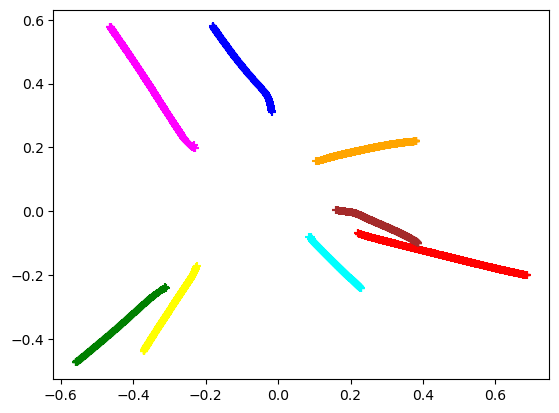

In [15]:
""" 
PCA decomposition of a single layer (the layer named 'net.2')

Number of samples = # training sessions * # weight samples per session

Each weight sample has dimension: 
    - layer 2 weights shape: (1, 100)
    
"""

n_samples_per_session = len(parameter_backups[0])
n_samples = training_sessions * n_samples_per_session 
n_features = parameter_backups[0][0]['net.2.weight'].cpu().numpy().shape[1] # 100

# allocate high-dim array of size (n_samples, n_features), which is the PCA input tensor
PCA_input_data = np.zeros((n_samples, n_features))

# populate high-dim input tensor 
for t in range(training_sessions):
    for i in range(n_samples_per_session): 
        PCA_input_data[t * n_samples_per_session + i, :] = parameter_backups[t][i]['net.2.weight'].cpu().numpy()

# compute 2D PCA-reduced data from weight samples
reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)

# plot 2D PCA data (each training session has different color)
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]
for t in range(training_sessions):
    plt.scatter(reduced_data.T[0][t*n_samples_per_session:(t+1)*n_samples_per_session], reduced_data.T[1][t*n_samples_per_session:(t+1)*n_samples_per_session], color=colors[t], marker='+')
plt.show()

### PCA of whole network ###

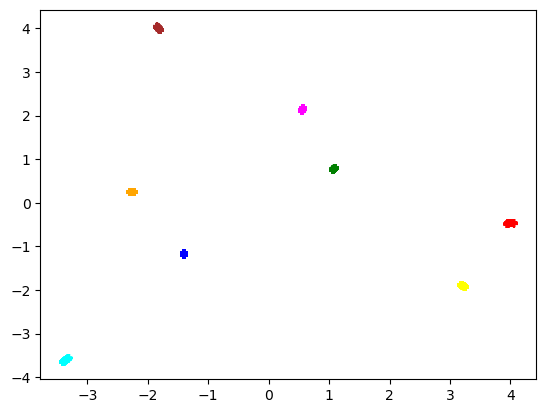

In [16]:
""" 
PCA decomposition of the whole network

Number of samples = # training sessions * # weight samples per session 

Each weight sample has now dimension given by the sum of the dims of all layers
    
"""

n_samples_per_session = len(parameter_backups[0])
n_samples = training_sessions * n_samples_per_session 

# stack together all layers to get feature dim
n_features = parameter_backups[0][0]['net.2.weight'].cpu().numpy().shape[1] # 100
n_features += parameter_backups[0][0]['net.0.weight'].cpu().numpy().shape[0] # +100

# allocate high-dim array of size (n_samples, n_features), which is the PCA input tensor
PCA_input_data = np.zeros((n_samples, n_features))

# populate high-dim input tensor 
for t in range(training_sessions):
    for i in range(n_samples_per_session): 
        arrays = [parameter_backups[t][i]['net.0.weight'].cpu().numpy(), parameter_backups[t][i]['net.2.weight'].cpu().numpy().T]
        PCA_input_data[t * n_samples_per_session + i, :] = np.vstack(arrays).T

# compute 2D PCA-reduced data from weight samples
reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)

# plot 2D PCA data (each training session has different color)
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]
for t in range(training_sessions):
    plt.scatter(reduced_data.T[0][t*n_samples_per_session:(t+1)*n_samples_per_session], reduced_data.T[1][t*n_samples_per_session:(t+1)*n_samples_per_session], color=colors[t], marker='+')
plt.show()

## 2.2 Observe gradient norm during training ##

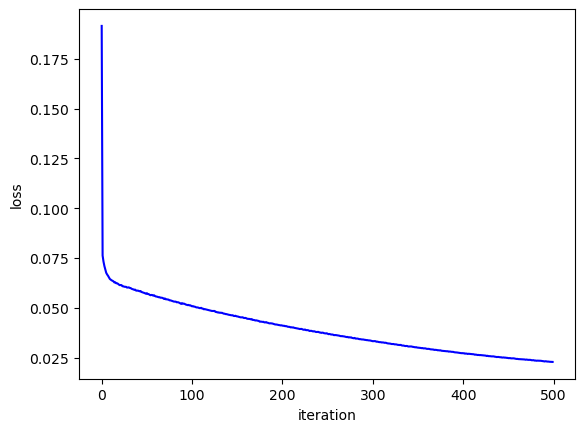

In [17]:
""" 
Plot training loss 

"""
plt.plot(training_loss[0], color='blue')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

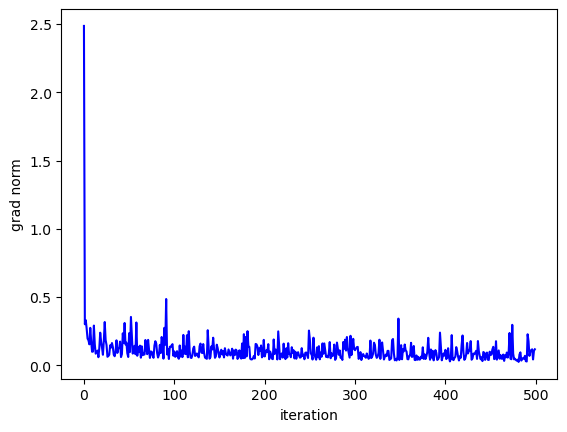

In [18]:
""" 
Plot grad norm 

"""
plt.plot(gradient_norm[0], color='blue')
plt.xlabel("iteration")
plt.ylabel("grad norm")
plt.show()

## 2.3 What happens when gradient is almost zero ##

In [19]:
# Using the following function:
def shifted_sync(x):
    return np.sin(5 * np.pi * (x + 0.0001))/(5 * np.pi * (x + 0.0001))

# generate training data
X_f = np.linspace(0, 1, 1000)
y_f1 = shifted_sync(X_f)

# convert numpy arrays to Tensors
tensor_x_f = torch.Tensor(X_f)
tensor_y_f1 = torch.Tensor(y_f1)
tensor_x_f = tensor_x_f.view(tensor_x_f.shape[0], 1).to(device)
tensor_y_f1 = tensor_y_f1.view(tensor_y_f1.shape[0], 1).to(device)

# create datasets and dataloaders
dataset_f1 = TensorDataset(tensor_x_f, tensor_y_f1)
dataloader_f1 = DataLoader(dataset_f1, batch_size = 256, shuffle = True)


# define a simple DNN model
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100), 
            nn.LeakyReLU(),
            nn.Linear(100, 1))

    def forward(self, x):
        return self.net(x)

# function to train and return a DNNModel
def train_model(dataloader, epochs = 20, lr = 1e-2):
    # instantiate model, define optimizer
    model = DNNModel().to(device)
    optimizer=optim.Adam(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    # train for range of epochs
    for epoch in range(epochs):
        for x_train, y_train in dataloader:
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

In [20]:
# autograd_lib function to compute hessian 
def compute_hessian(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A)
    # full Hessian
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)

# autograd_lib function to save activations
def store_activations(layer, A, _):
    activations[layer] = A
    
# function to compute the minimum ratio (proportion of eigenvalues > 0)
def compute_minimum_ratio(model, obj_fn, tensor_x, tensor_y):
    # zero out grad
    model.zero_grad()

    # recompute grad
    with autograd_lib.module_hook(store_activations):
        y_pred = model(tensor_x)
        loss = obj_fn(y_pred, tensor_y)

    # compute hessian with autograd_lib
    with autograd_lib.module_hook(compute_hessian):
        autograd_lib.backward_hessian(y_pred, loss='LeastSquares')

    # compute hessian eigenvalues
    hessians = list(hess.values())
    minimum_ratio = []
    for hessian in hessians:
        size = hessian.shape[1] * hessian.shape[0]
        hessian = hessian.reshape(size, size)
        eigens = torch.symeig(hessian).eigenvalues 
        # compute minimum ratio as the ratio of eigenvalues > 0 over the total number of eigenvalues
        minimum_ratio.append(torch.sum(eigens > 0).item() / len(eigens))

    # return avg min ratio value
    return np.mean(minimum_ratio) 

# function to compute gradient norm and loss
def compute_grad_norm_loss(model, obj_fn, tensor_x, tensor_y):
    # set model mode to train, zero out grads
    model.train()
    model.zero_grad()
    
    # compute output and loss
    y_pred = model(tensor_x)
    loss = obj_fn(y_pred, tensor_y)
    loss.backward()

    # compute mean grad norm across all layers
    grad_norms = []
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            layer_grad_norm = layer.weight.grad.norm(2).item()
            grad_norms.append(layer_grad_norm)
    grad_norm = np.mean(grad_norms)
    
    return grad_norm, loss

In [21]:
"""
Train 100 times and compute min ratios

"""

loss_fn = nn.MSELoss()

# keep track of minimum ratios, grad norms, losses 
minimum_ratios = []
grad_norms = []
losses = []

# train 100 times
for i in range(100):
    hess = defaultdict(float)
    activations = defaultdict(int)
    
    # start by training a model on the training set
    model = train_model(dataloader_f1)
    autograd_lib.register(model)

    # then compute grad norm, loss, min ratio
    obj_fn = nn.MSELoss()
    grad_norm, loss = compute_grad_norm_loss(model, obj_fn, tensor_x_f, tensor_y_f1)
    minimum_ratio = compute_minimum_ratio(model, obj_fn, tensor_x_f, tensor_y_f1)

    # store grad norm, loss, min ratio
    grad_norms.append(grad_norm)
    losses.append(loss)
    minimum_ratios.append(minimum_ratio)
    
    if i % 10 == 0: 
        print("Training n." + str(i) + " completed...")

print("Done")

C:\Users\FJ\.conda\envs\ML_py38\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\FJ\AppData\Local\Temp\ipykernel_4240\1792337492.py:32: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper el

Training n.0 completed...
Training n.10 completed...
Training n.20 completed...
Training n.30 completed...
Training n.40 completed...
Training n.50 completed...
Training n.60 completed...
Training n.70 completed...
Training n.80 completed...
Training n.90 completed...
Done


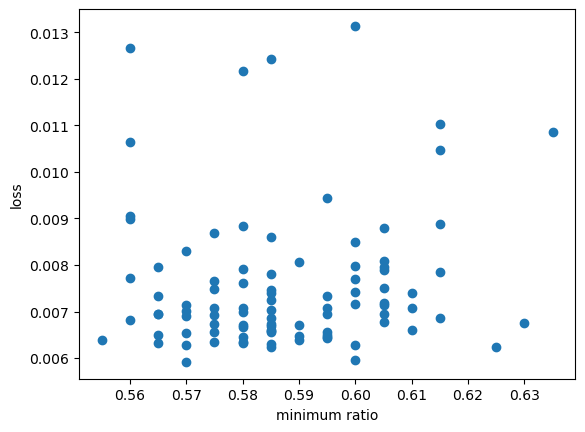

In [22]:
# max grad threshold
thresh = 0.1

# plot data
minimum_ratio_plot=[]
loss_plot=[]

# find min ratio/loss of small grad norms
for i in range(len(grad_norms)):
    if grad_norms[i] < thresh:
        minimum_ratio_plot.append(minimum_ratios[i])
        loss_plot.append(losses[i].detach().cpu().numpy())


plt.scatter(minimum_ratio_plot, loss_plot)
plt.xlabel("minimum ratio")
plt.ylabel("loss")
plt.show()

# HW1-3: Generalization #

## 3.1 Can the network fit random labels? ##

In [23]:
"""
MNIST dataset with random labels

"""
# get MNIST training and test sets
MNIST_trainset = datasets.MNIST(root='./MNIST_data/', train = True, download=True, transform=ToTensor())
MNIST_testset = datasets.MNIST(root='./MNIST_data/', train = False, download=True, transform=ToTensor())

# set labels to random values
MNIST_trainset.targets = torch.randint(0, 10, MNIST_trainset.targets.shape)
MNIST_testset.targets = torch.randint(0, 10, MNIST_testset.targets.shape)

# define train and test data loaders
trainset_loader = DataLoader(MNIST_trainset, batch_size=64, shuffle=True, num_workers=2)
testset_loader = DataLoader(MNIST_testset, batch_size=64, shuffle=False, num_workers=2)

In [24]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10))

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)


# instantiate DNN model, move it to main computing device
dnn_model = DNNModel().to(device)

In [25]:
"""
Train and evaluate model on random MNIST dataset

"""

# function to evaluate model loss against test dataset
def evaluate_test_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    # train and store epoch training loss
    epoch_test_loss = 0.0
    for batch, (X_test, y_test) in enumerate(dataloader): 
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # compute model predictions and loss
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_test_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_test_loss
    
    
# function to train a model on the provided dataset for 1 epoch
def train_dnn(dataloader, model):
    # define cost function (cross entropy loss for classification) and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # set model to train mode
    model.train()

    # train and store epoch training loss
    epoch_training_loss = 0.0
    for batch, (X_train, y_train) in enumerate(dataloader): 
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # reset gradients to zero
        optimizer.zero_grad()

        # compute model predictions and loss
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        
        # perform optimization step
        loss.backward()
        optimizer.step()

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_training_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_training_loss

# function to perform the main train-evaluate cycle
def train_and_evaluate(trainset_loader, testset_loader, model, epochs=50):
    
    # keep track of training and test loss for all epochs
    training_loss = []
    test_loss = []
    
    for epoch in range(epochs):
        # train for one epoch
        epoch_training_loss = train_dnn(trainset_loader, model)
        training_loss.append(epoch_training_loss)
        
        # evaluate loss on test set 
        epoch_test_loss = evaluate_test_loss(testset_loader, model)
        test_loss.append(epoch_test_loss)

        # print info
        if (epoch % 5 == 0) or (epoch == (epochs-1)):
            print("Epoch " + str(epoch) + ", training loss: " + str(epoch_training_loss) 
                + ", test loss: " + str(epoch_test_loss))
            
    # return training loss, train accuracy and test accuracy for all epochs
    return training_loss, test_loss


# train model
print("Training model on random MNIST...")
training_loss, test_loss = train_and_evaluate(trainset_loader, testset_loader, dnn_model)

Training model on random MNIST...
Epoch 0, training loss: 2.3044064766816774, test loss: 2.302711063129886
Epoch 5, training loss: 2.290590252957617, test loss: 2.310719951702533
Epoch 10, training loss: 2.246194542089761, test loss: 2.349279883560861
Epoch 15, training loss: 2.1945794421726728, test loss: 2.3808776436338004
Epoch 20, training loss: 2.1448189500552486, test loss: 2.4318668948616957
Epoch 25, training loss: 2.102519823544057, test loss: 2.48616666247131
Epoch 30, training loss: 2.062893186423822, test loss: 2.5596812044738946
Epoch 35, training loss: 2.027829327562978, test loss: 2.606692288331924
Epoch 40, training loss: 1.9949552292254458, test loss: 2.6759065412412024
Epoch 45, training loss: 1.9657509956024337, test loss: 2.7413454936568136
Epoch 49, training loss: 1.9433150086829905, test loss: 2.8021829204194857


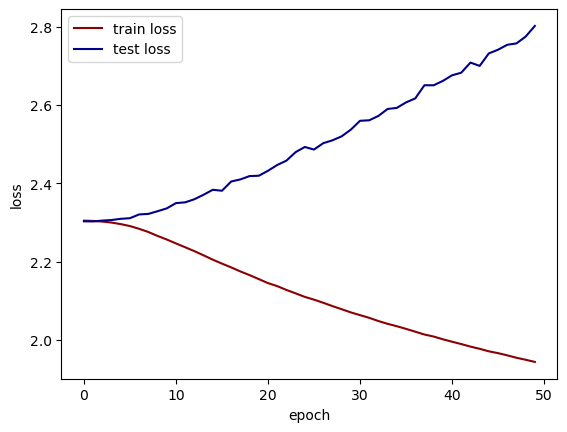

In [26]:
""" 
Plot train and test loss 

"""
plt.plot(training_loss, color='darkred')
plt.plot(test_loss, color='darkblue')
plt.legend(["train loss", "test loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## 3.2 Number of parameters VS generalization ##

In [27]:
"""
MNIST dataset

"""
# get MNIST training and test sets
MNIST_trainset = datasets.MNIST(root='./MNIST_data/', train = True, download=True, transform=ToTensor())
MNIST_testset = datasets.MNIST(root='./MNIST_data/', train = False, download=True, transform=ToTensor())

# define train and test data loaders
trainset_loader = DataLoader(MNIST_trainset, batch_size=64, shuffle=True, num_workers=2)
testset_loader = DataLoader(MNIST_testset, batch_size=64, shuffle=False, num_workers=2)

In [28]:
class DNNModel(nn.Module):
    def __init__(self, hidden_size):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10))

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

def params_count(model):
    return sum(params.numel() for params in model.parameters() if params.requires_grad)

num_models = 10
models = []
model_param_counts = []

for i in range(num_models): 
    models.append(DNNModel(hidden_size=((i+1)*3)).to(device))
    model_param_counts.append(params_count(models[i]))
    print("Model", i, ", number of parameters:", model_param_counts[i])

Model 0 , number of parameters: 2395
Model 1 , number of parameters: 4780
Model 2 , number of parameters: 7165
Model 3 , number of parameters: 9550
Model 4 , number of parameters: 11935
Model 5 , number of parameters: 14320
Model 6 , number of parameters: 16705
Model 7 , number of parameters: 19090
Model 8 , number of parameters: 21475
Model 9 , number of parameters: 23860


In [29]:
"""
Train and evaluate all models

"""

# function to evaluate model accuracy against the provided dataset
def evaluate_accuracy(dataloader, model): 
    model.eval()
    correct = 0
    
    # compute amount of correct predictions (class with max predicted probability == ground-truth label)
    for input_data, labels in dataloader: 
        input_data = input_data.to(device)
        labels = labels.to(device)
        y_pred = model(input_data)
        y_pred_one_hot = y_pred.data.max(1, keepdim=True)[1]
        correct += y_pred_one_hot.eq(labels.data.view_as(y_pred_one_hot)).cpu().sum()

    # return % accuracy 
    return 100 * correct.item() / len(dataloader.dataset)
    

# function to evaluate model loss against test dataset
def evaluate_test_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    # train and store epoch training loss
    epoch_test_loss = 0.0
    for batch, (X_test, y_test) in enumerate(dataloader): 
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # compute model predictions and loss
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_test_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_test_loss
    
    
# function to train a model with the provided dataset for 1 epoch
def train_dnn(dataloader, model):
    # define cost function (cross entropy loss for classification) and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # set model to train mode
    model.train()

    # train and store epoch training loss
    epoch_training_loss = 0.0
    for batch, (X_train, y_train) in enumerate(dataloader): 
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # reset gradients to zero
        optimizer.zero_grad()

        # compute model predictions and loss
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        
        # perform optimization step
        loss.backward()
        optimizer.step()

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_training_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_training_loss

# function to perform the main train-evaluate cycle
def train_and_evaluate(trainset_loader, testset_loader, model, epochs=10):
    
    # store training and test loss/accuracy on last epoch
    training_loss = None
    test_loss = None
    train_accuracy = None
    test_accuracy = None
    
    for epoch in range(epochs):
        
        if epoch < (epochs - 1):
            training_loss = train_dnn(trainset_loader, model)
            # print info
            if (epoch % 5 == 0):
                print("Epoch " + str(epoch) + ", training loss: " + str(training_loss))
                
        else: # record loss and accuracy only on last epoch

            # train for one epoch
            training_loss = train_dnn(trainset_loader, model)

            # evaluate loss on test set 
            test_loss = evaluate_test_loss(testset_loader, model)

            # evaluate accuracy on train set 
            train_accuracy = evaluate_accuracy(trainset_loader, model)

            # evaluate accuracy on test set 
            test_accuracy = evaluate_accuracy(testset_loader, model)
            
            # print info
            print("Epoch " + str(epoch) + ", training loss: " + str(training_loss) 
                + ", test loss: " + str(test_loss)
                + ", train accuracy: " + str(train_accuracy) + "%"
                + ", test accuracy: " + str(test_accuracy) + "%")



            
    # return training and test loss/accuracy at end of training
    return training_loss, test_loss, train_accuracy, test_accuracy


# train all models on MNIST dataset

plot_data_train_losses = []
plot_data_test_losses = []
plot_data_train_accs = []
plot_data_test_accs = []

for i in range(num_models): 
    print("\nTraining model", i, "on MNIST...")
    training_loss, test_loss, train_accuracy, test_accuracy = train_and_evaluate(trainset_loader, testset_loader, models[i])
    plot_data_train_losses.append(training_loss) 
    plot_data_test_losses.append(test_loss) 
    plot_data_train_accs.append(train_accuracy)
    plot_data_test_accs.append(test_accuracy) 
print("Done.")


Training model 0 on MNIST...
Epoch 0, training loss: 1.4561788767004298
Epoch 5, training loss: 0.7495735487195732
Epoch 9, training loss: 0.6940259462925419, test loss: 0.6914514924880046, train accuracy: 79.62666666666667%, test accuracy: 79.52%

Training model 1 on MNIST...
Epoch 0, training loss: 1.01122176049869
Epoch 5, training loss: 0.35916494593214837
Epoch 9, training loss: 0.3252360504636887, test loss: 0.32363323026164714, train accuracy: 91.03666666666666%, test accuracy: 91.15%

Training model 2 on MNIST...
Epoch 0, training loss: 0.6536994293046144
Epoch 5, training loss: 0.2599331602605101
Epoch 9, training loss: 0.239128352498322, test loss: 0.25022911774528467, train accuracy: 93.49833333333333%, test accuracy: 92.85%

Training model 3 on MNIST...
Epoch 0, training loss: 0.610504929397279
Epoch 5, training loss: 0.21893684283248413
Epoch 9, training loss: 0.19061225879071617, test loss: 0.188820421888499, train accuracy: 94.86833333333334%, test accuracy: 94.59%

Tra

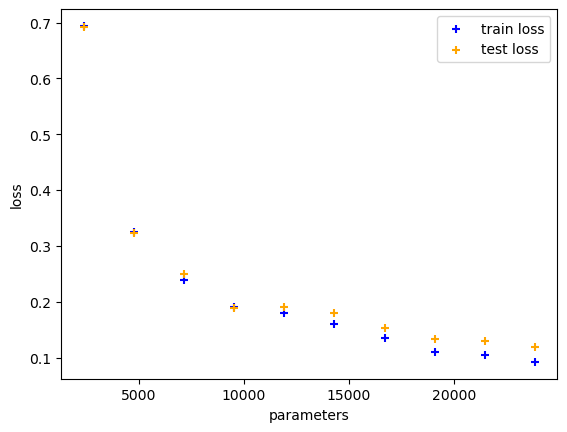

In [30]:
""" 
Plot training loss 

"""

plt.scatter(model_param_counts, plot_data_train_losses, color='blue', marker='+')
plt.scatter(model_param_counts, plot_data_test_losses, color='orange', marker='+')
plt.legend(["train loss", "test loss"])
plt.xlabel("parameters")
plt.ylabel("loss")
plt.show()

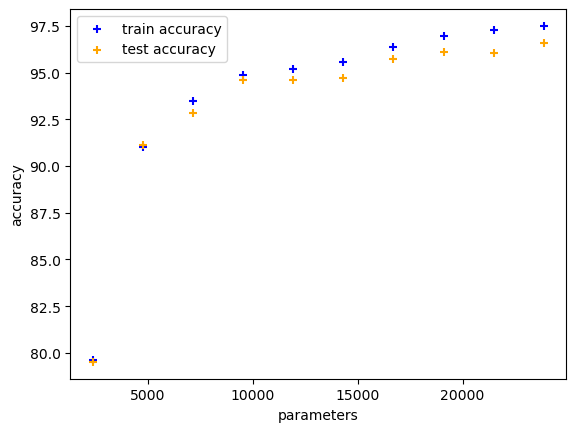

In [31]:
""" 
Plot accuracy 

"""

plt.scatter(model_param_counts, plot_data_train_accs, color='blue', marker='+')
plt.scatter(model_param_counts, plot_data_test_accs, color='orange', marker='+')
plt.legend(["train accuracy", "test accuracy"])
plt.xlabel("parameters")
plt.ylabel("accuracy")
plt.show()

## 3.3 Flatness VS Generalization ##

### Part 1: visualize line between two trained models ###

In [32]:
"""
MNIST dataset

"""
# get MNIST training and test sets
MNIST_trainset = datasets.MNIST(root='./MNIST_data/', train = True, download=True, transform=ToTensor())
MNIST_testset = datasets.MNIST(root='./MNIST_data/', train = False, download=True, transform=ToTensor())

# define train and test data loaders
trainset_loader = DataLoader(MNIST_trainset, batch_size=64, shuffle=True, num_workers=2)
testset_loader = DataLoader(MNIST_testset, batch_size=64, shuffle=False, num_workers=2)

In [33]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 10))

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

# instantiate two models
dnn_model_A = DNNModel().to(device)
dnn_model_B = DNNModel().to(device)

In [34]:
"""
Train the two models, then interpolate weights and evaluate

"""

# function to evaluate model accuracy against the provided dataset
def evaluate_accuracy(dataloader, model): 
    model.eval()
    correct = 0
    
    # compute amount of correct predictions (class with max predicted probability == ground-truth label)
    for input_data, labels in dataloader: 
        input_data = input_data.to(device)
        labels = labels.to(device)
        y_pred = model(input_data)
        y_pred_one_hot = y_pred.data.max(1, keepdim=True)[1]
        correct += y_pred_one_hot.eq(labels.data.view_as(y_pred_one_hot)).cpu().sum()

    # return % accuracy 
    return 100 * correct.item() / len(dataloader.dataset)
    

# function to evaluate model loss against dataset
def evaluate_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    # compute epoch loss
    epoch_test_loss = 0.0
    for batch, (X_test, y_test) in enumerate(dataloader): 
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # compute model predictions and loss
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_test_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_test_loss
    
    
# function to train a model with the provided dataset
def train_dnn(dataloader, model, epochs=10, lr=1e-3):
    # define cost function (cross entropy loss for classification) and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # set model to train mode
    model.train()

    for epoch in range(epochs):
        epoch_training_loss = 0.0
        for batch, (X_train, y_train) in enumerate(dataloader): 
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            # reset gradients to zero
            optimizer.zero_grad()

            # compute model predictions and loss
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)

            # perform optimization step
            loss.backward()
            optimizer.step()

            # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
            epoch_training_loss += loss.item() / len(dataloader)
        
        # print info
        if (epoch % 5 == 0):
            print("Epoch " + str(epoch) + ", training loss: " + str(epoch_training_loss))



def interpolate_models(model_A, model_B, alpha):
    interpolated_model = DNNModel().to(device)
    # set weights
    for p in interpolated_model.state_dict():
        p_a = model_A.state_dict()[p].cpu().numpy()
        p_b = model_B.state_dict()[p].cpu().numpy()
        interpolated_model.state_dict()[p][:] = torch.Tensor((1-alpha)*p_a + alpha*p_b)
    
    return interpolated_model.to(device)
    


alpha_values = np.linspace(-1, 2, 50)
plot_data_train_losses = []
plot_data_test_losses = []
plot_data_train_accs = []
plot_data_test_accs = []

# train models
print("Training model A on MNIST...")
train_dnn(trainset_loader, dnn_model_A, lr=1e-3)

print("\nTraining model B on MNIST...")
train_dnn(trainset_loader, dnn_model_B, lr=1e-2)

# evaluate interpolated models
print("\nEvaluating interpolated models...")
for alpha in alpha_values: 
    print("alpha:", alpha)
    interpolated_model = interpolate_models(dnn_model_A, dnn_model_B, alpha)
    training_loss = evaluate_loss(trainset_loader, interpolated_model)
    test_loss = evaluate_loss(testset_loader, interpolated_model)
    train_accuracy = evaluate_accuracy(trainset_loader, interpolated_model)
    test_accuracy = evaluate_accuracy(testset_loader, interpolated_model)
    
    plot_data_train_losses.append(training_loss) 
    plot_data_test_losses.append(test_loss) 
    plot_data_train_accs.append(train_accuracy)
    plot_data_test_accs.append(test_accuracy) 
print("Done.")

Training model A on MNIST...
Epoch 0, training loss: 0.6167015903540002
Epoch 5, training loss: 0.2488231230487444

Training model B on MNIST...
Epoch 0, training loss: 0.3786663508602683
Epoch 5, training loss: 0.22439694281683345

Evaluating interpolated models...
alpha: -1.0
alpha: -0.9387755102040817
alpha: -0.8775510204081632
alpha: -0.8163265306122449
alpha: -0.7551020408163265
alpha: -0.6938775510204082
alpha: -0.6326530612244898
alpha: -0.5714285714285714
alpha: -0.5102040816326531
alpha: -0.44897959183673475
alpha: -0.3877551020408163
alpha: -0.326530612244898
alpha: -0.26530612244897966
alpha: -0.20408163265306123
alpha: -0.1428571428571429
alpha: -0.08163265306122447
alpha: -0.020408163265306145
alpha: 0.04081632653061229
alpha: 0.1020408163265305
alpha: 0.16326530612244894
alpha: 0.22448979591836737
alpha: 0.2857142857142856
alpha: 0.346938775510204
alpha: 0.40816326530612246
alpha: 0.46938775510204067
alpha: 0.5306122448979591
alpha: 0.5918367346938775
alpha: 0.65306122448

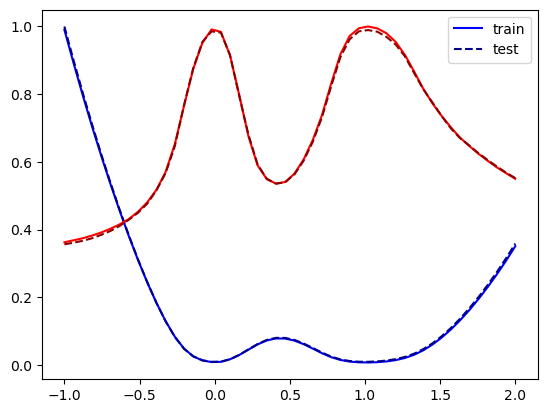

In [35]:
# normalize scales for loss and accuracy
max_loss = 0
max_acc = 0

for l in plot_data_train_losses + plot_data_test_losses:
    if l > max_loss: 
        max_loss = l

for a in plot_data_train_accs + plot_data_test_accs:
    if a > max_acc: 
        max_acc = a

for i in range(len(plot_data_train_losses)): 
    plot_data_train_losses[i] /= max_loss

for i in range(len(plot_data_test_losses)): 
    plot_data_test_losses[i] /= max_loss

for i in range(len(plot_data_train_accs)): 
    plot_data_train_accs[i] /= max_acc
    
for i in range(len(plot_data_test_accs)): 
    plot_data_test_accs[i] /= max_acc

# plot loss and accuracy, for both train and test
plt.plot(alpha_values, plot_data_train_losses, color='blue')
plt.plot(alpha_values, plot_data_test_losses, color='darkblue', linestyle="--")
plt.plot(alpha_values, plot_data_train_accs, color='red')
plt.plot(alpha_values, plot_data_test_accs, color='darkred', linestyle="--")
plt.legend(["train", "test"])

### Part 2: Sensitivity ###  

In [36]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from autograd_lib import autograd_lib
import torch.nn.functional as F     # Contains all the functions in the torch.nn library


# define preferred pytorch device (gpu, if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using " + device + " device")

Using cuda device


In [37]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 10))

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

In [38]:
"""
MNIST dataset

"""

# get MNIST training and test sets
MNIST_trainset = datasets.MNIST(root='./MNIST_data/', train = True, download=True, transform=ToTensor())
MNIST_testset = datasets.MNIST(root='./MNIST_data/', train = False, download=True, transform=ToTensor())

# define train and test data loaders
trainset_loader = DataLoader(MNIST_trainset, batch_size=64, shuffle=True, num_workers=2)
testset_loader = DataLoader(MNIST_testset, batch_size=64, shuffle=False, num_workers=2)

In [39]:
# function to evaluate model accuracy against the provided dataset
def evaluate_accuracy(dataloader, model): 
    model.eval()
    correct = 0
    
    # compute amount of correct predictions (class with max predicted probability == ground-truth label)
    for input_data, labels in dataloader: 
        input_data = input_data.to(device)
        labels = labels.to(device)
        y_pred = model(input_data)
        y_pred_one_hot = y_pred.data.max(1, keepdim=True)[1]
        correct += y_pred_one_hot.eq(labels.data.view_as(y_pred_one_hot)).cpu().sum()

    # return % accuracy 
    return 100 * correct.item() / len(dataloader.dataset)
    

# function to evaluate model loss against dataset (without training the params)
def evaluate_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    # compute epoch loss
    epoch_test_loss = 0.0
    for batch, (X_test, y_test) in enumerate(dataloader): 
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        # compute model predictions and loss
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_test_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_test_loss
    
    
# function to train a model with the provided dataset for one epoch. Returns training loss and sensitivity
def train_dnn(dataloader, model, lr=1e-3):
    # define cost function (cross entropy loss for classification) and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # set model to train mode
    model.train()
    
    epoch_training_loss = 0.0
    epoch_sensitivity = 0.0
    
    for batch, (X_train, y_train) in enumerate(dataloader): 
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # compute model predictions and loss
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
  
        # update sensitivity with batch grad (epoch sensitivity := mean sensitivity across all batches)
        grads_p = torch.autograd.grad(loss, model.parameters(), create_graph=True)[0]
        epoch_sensitivity += grads_p.norm(2).detach().cpu().item() / len(dataloader)
        
        # perform optimization step
        loss.backward()
        optimizer.step()

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_training_loss += loss.item() / len(dataloader)
    
    return epoch_training_loss, epoch_sensitivity

#torch.autograd.set_detect_anomaly(True)
epochs=10

# store data (one sample per model)
training_loss_data=[]
test_loss_data=[]
training_accuracy_data=[]
test_accuracy_data=[]
sensitivity_data=[]

# training 5 models using 5 different learning rates
learning_rates = [5e-2, 1e-2, 5e-3, 1e-3, 1e-4]

for learning_rate_i in learning_rates:  
    print("Training model with learning rate: ", learning_rate_i)
    
    # store train/test accuracy and loss, and sensitivity, for all epochs
    train_accuracies=[]
    test_accuracies=[]
    train_losses=[]
    test_losses=[]
    sensitivities=[]
    
    # instantiate model, move to device
    model = DNNModel().to(device)

    for epoch in range(10):
        print("epoch:", epoch)
        
        # train model, compute training loss and sensitivity
        training_loss, sensitivity = train_dnn(trainset_loader, model, lr=learning_rate_i)
           
        # evaluate loss on test set
        test_loss = evaluate_loss(testset_loader, model)
        
        # evaluate accuracy on train set
        train_accuracy = evaluate_accuracy(trainset_loader, model)
        
        # evaluate accuracy on test set
        test_accuracy = evaluate_accuracy(testset_loader, model)

        # store epoch stats
        train_losses.append(training_loss)
        train_accuracies.append(train_accuracy)
        sensitivities.append(sensitivity)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    # store mean values for current model
    test_loss_data.append(np.mean(test_losses))
    test_accuracy_data.append(np.mean(test_accuracies))
    training_loss_data.append(np.mean(train_losses))
    training_accuracy_data.append(np.mean(train_accuracies))
    sensitivity_data.append(np.mean(sensitivities))

Training model with learning rate:  0.05
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.01
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.005
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.001
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Training model with learning rate:  0.0001
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


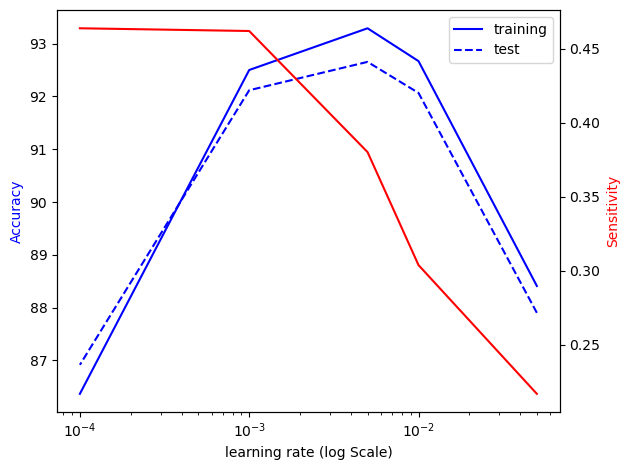

In [40]:
"""
Plot accuracy and sensitivity

"""

fig, ax1 = plt.subplots()
ax1.set_xlabel('learning rate (log Scale)')
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(learning_rates, training_accuracy_data, color='blue', label="training")
ax1.plot(learning_rates, test_accuracy_data, '--', color='blue', label="test")
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Sensitivity', color='red')
ax2.plot(learning_rates, sensitivity_data, color='red', label="sensitivity")
fig.tight_layout()
plt.show()

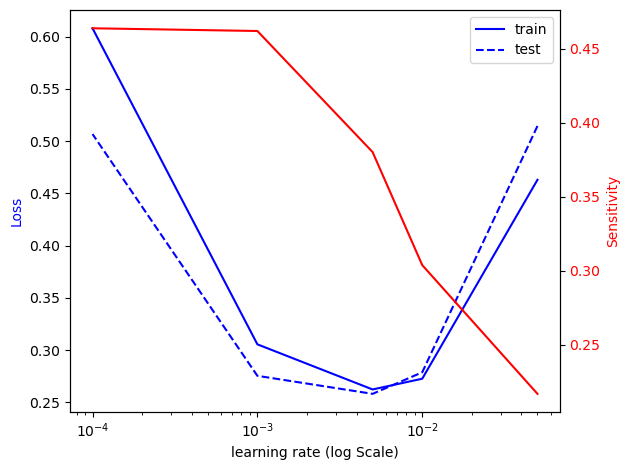

In [43]:
"""
Plot loss and sensitivity

"""

fig, ax1 = plt.subplots()
ax1.set_xlabel('learning rate (log Scale)')
ax1.set_xscale('log')
ax1.set_ylabel('Loss', color='blue')
ax1.plot(learning_rates, training_loss_data, color='blue', label="train")
ax1.plot(learning_rates, test_loss_data, '--', color='blue', label="test")
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Sensitivity', color='red')
ax2.plot(learning_rates,sensitivity_data,color='red',label="sensitivity")
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
plt.show()